<a href="https://colab.research.google.com/github/Tboyfist/Deep-Learning/blob/main/Corrected_copy_of_week6_tensorflowhub_with_your_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning with TensorFlow Hub


[TensorFlow Hub](https://tfhub.dev/) is a repository of pre-trained TensorFlow models.

This workshop demonstrates how to:

1. Use models from TensorFlow Hub with `tf.keras`.
1. Use an image classification model from TensorFlow Hub.
1. Do simple transfer learning to fine-tune a model for your own image classes.

## Setup

In [1]:
!pip install tensorflow==2.10.0 tensorflow-hub==0.12.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.0/578.0 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.8/108.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 27.2 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data

## An ImageNet classifier

You'll start by using a classifier model pre-trained on the [ImageNet](https://en.wikipedia.org/wiki/ImageNet) benchmark dataset—no initial training required!

### Download the classifier

Select a <a href="https://arxiv.org/abs/1801.04381" class="external">MobileNetV2</a> pre-trained model [from TensorFlow Hub](https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2) and wrap it as a Keras layer with [`hub.KerasLayer`](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer). Any <a href="https://tfhub.dev/s?q=tf2&module-type=image-classification/" class="external">compatible image classifier model</a> from TensorFlow Hub will work here, including the examples provided in the drop-down below.

In [1]:
# This lines define the URLs for two pre-trained models mobilenet_v2 and inception_v3
mobilenet_v2 ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
inception_v3 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"

# This helps to easily switch between different pre-trained models for image classification. By changing the value of classifier_model
classifier_model = mobilenet_v2 #@param ["mobilenet_v2", "inception_v3"] {type:"raw"}

In [2]:
# This command is setting up a TensorFlow model using a pre-trained classifier from TensorFlow Hub
import tensorflow as tf
import tensorflow_hub as hub

#This line defines the shape of the input images
IMAGE_SHAPE = (224, 224)

#This creates a sequential model in TensorFlow
classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
])

### Run it on a single image

Download a single image to try the model on:

In [3]:
from PIL import Image
import numpy as np

# Download the image of Grace Hopper from a URL and saves it locally
grace_hopper = tf.keras.utils.get_file('image.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')

# Open and resize the image
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)

61306/61306 [==============================] - 0s 3us/step


In [4]:
#This line prints the shape of the numpy array suitable for input into a machine learning model
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

Add a batch dimension (with `np.newaxis`) and pass the image to the model:

In [5]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

1/1 [==============================] - 1s 544ms/step


(1, 1001)

The result is a 1001-element vector of logits, rating the probability of each class for the image.

The top class ID can be found with `tf.math.argmax`:

In [6]:
predicted_class = tf.math.argmax(result[0], axis=-1)
predicted_class

<tf.Tensor: shape=(), dtype=int64, numpy=653>

### Decode the predictions

Take the `predicted_class` ID (such as `653`) and fetch the ImageNet dataset labels to decode the predictions:

In [7]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

10484/10484 [==============================] - 0s 0us/step


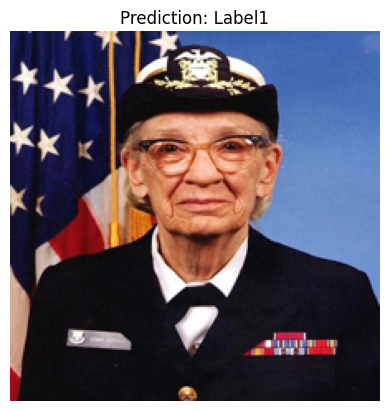

In [8]:
import matplotlib.pyplot as plt

# Display the image
plt.imshow(grace_hopper)
plt.axis('off')

# Assuming you have the predicted class and labels
predicted_class = 0  # Replace with your actual predicted class index
imagenet_labels = ["label1", "label2", "label3"]  # Replace with your actual labels

predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())
plt.show()


## Simple transfer learning

But what if you want to create a custom classifier using your own dataset that has classes that aren't included in the original ImageNet dataset (that the pre-trained model was trained on)?

To do that, you can:

1. Select a pre-trained model from TensorFlow Hub; and
2. Retrain the top (last) layer to recognize the classes from your custom dataset.

### Dataset

In this example, you will use the unversity of Salford buildings dataset:

In [9]:
import pathlib
dataset_url = "https://salford.figshare.com/ndownloader/files/36524085"
data_dir = tf.keras.utils.get_file('dataset', origin=dataset_url, untar=True, cache_dir = '/content')
data_dir = pathlib.Path(data_dir)

3037144022/3037144022 [==============================] - 187s 0us/step


If you have your dataset collected by yourself, upload to your google drive and use the below code:

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
#import pathlib
#data_dir = "/content/drive/MyDrive/dataset/"
#data_dir = pathlib.Path(data_dir)

First, load this data into the model using the image data off disk with `tf.keras.utils.image_dataset_from_directory`, which will generate a `tf.data.Dataset`:

In [10]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

In [11]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

Found 751 files belonging to 10 classes.
Using 601 files for training.


In [12]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

Found 751 files belonging to 10 classes.
Using 150 files for validation.


In [13]:
train_ds = train_dataset
val_ds = validation_dataset

See classes of the dataset:

In [14]:
class_names = np.array(train_ds.class_names)
print(class_names)

['Chapman' 'Cockcroft' 'Library' 'Maxwell' 'Media City Campus'
 'New Adelphi' 'New Science' 'Newton' 'Sports Center' 'University House']


Second, because TensorFlow Hub's convention for image models is to expect float inputs in the `[0, 1]` range, use the `tf.keras.layers.Rescaling` preprocessing layer to achieve this.

Note: You could also include the `tf.keras.layers.Rescaling` layer inside the model. Refer to the [Working with preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) guide for a discussion of the tradeoffs.

In [15]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

In [16]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [17]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


### Run the classifier on a batch of images

Now, run the classifier on an image batch:

In [18]:
result_batch = classifier.predict(train_ds)

19/19 [==============================] - 67s 2s/step


In [25]:
# Assuming result_batch is your model's output
predicted_class_indices = tf.math.argmax(result_batch, axis=-1).numpy()

# Print the indices to debug
print(predicted_class_indices)

# Handle out-of-range indices
predicted_class_names = [imagenet_labels[idx] if idx < len(imagenet_labels) else "Unknown" for idx in predicted_class_indices]

predicted_class_names



[490 520 499 822 808 661 406 664 625 707 499 707 728 570 719 558 566 744
 707 664 411 744 426 717 878 511 782 625 707 744 566 469 499 661 859 661
 520 859 664 707 744 449 744 558 808 699 443 683 874 661 699 744 813 920
 450 744 920 625 744 699 518 566 744 859 859 661 661 822 844 699 581 625
 859 699 808 734 859 744 913 707 808 920 920 625 707 744 744 744 744 661
 826 625 744 744 744 744 734 744 699 518 868 699 499 566 683 921 976 426
 744 625 499 511 744 830 744 744 511 664 744 426 744 707 707 566 859 744
 979 744 664 889 782 499 558 744 706 661 744 499 782 661 699 782 661 699
 664 754 661 707 719 664 782 566 921 920 450 499 548 744 499 556 699 744
 707 734 499 744 744 518 426 499 744 744 921 744 921 830 426 558 921 625
 499 920 425 507 566 744 664 707 664 808 699 708 744 566 629 661 499 676
 661 449 558 628 808 518 921 566 744 661 744 664 830 699 661 499 426 744
 808 859 808 739 744 734 548 566 699 744 499 744 707 518 499 499 717 744
 808 859 661 808 566 661 704 717 744 485 459 859 62

['Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Un

Check how these predictions line up with the images:

Max index: 979


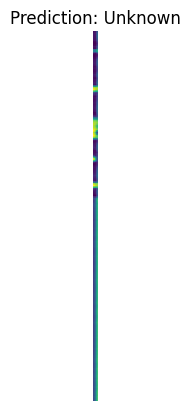

['Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown'

In [26]:
# Assuming result_batch is your model's output
predicted_class_indices = tf.math.argmax(result_batch, axis=-1).numpy()

# Print the maximum index and the length of imagenet_labels
print("Max index:", max(predicted_class_indices))

# Handle out-of-range indices
predicted_class_names = [imagenet_labels[idx] if idx < len(imagenet_labels) else "Unknown" for idx in predicted_class_indices]

# Display the image and prediction
plt.imshow(grace_hopper[0])
plt.axis('off')
_ = plt.title("Prediction: " + predicted_class_names[0].title())
plt.show()

print(predicted_class_names)


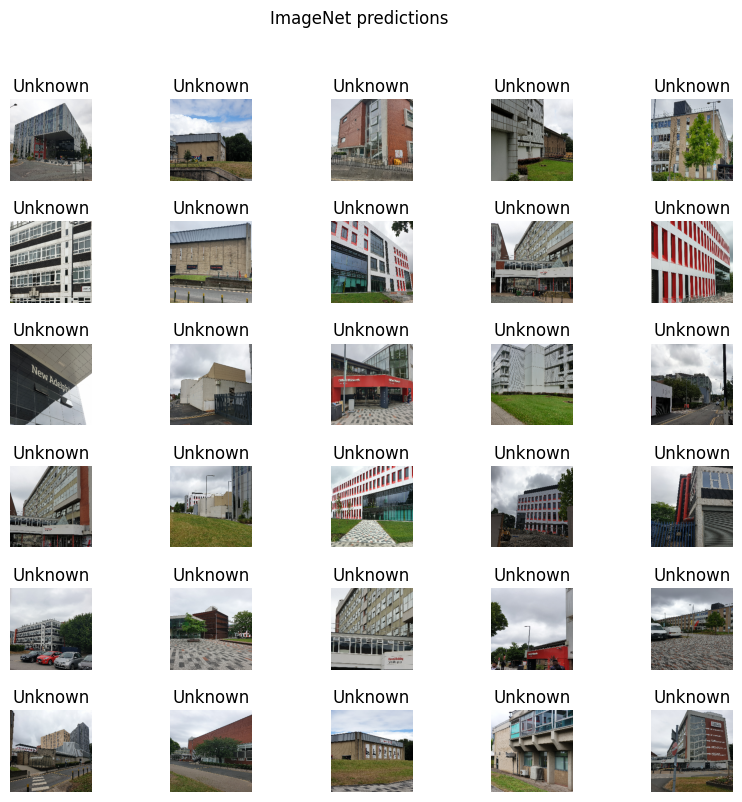

In [27]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

The results are far from perfect, but reasonable considering that these are not

### Download the headless model

TensorFlow Hub also distributes models without the top classification layer. These can be used to easily perform transfer learning.

Select a <a href="https://arxiv.org/abs/1801.04381" class="external">MobileNetV2</a> pre-trained model <a href="https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4" class="external">from TensorFlow Hub</a>. Any <a href="https://tfhub.dev/s?module-type=image-feature-vector&q=tf2" class="external">compatible image feature vector model</a> from TensorFlow Hub will work here, including the examples from the drop-down menu.

In [28]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

feature_extractor_model = mobilenet_v2 #@param ["mobilenet_v2", "inception_v3"] {type:"raw"}

Create the feature extractor by wrapping the pre-trained model as a Keras layer with [`hub.KerasLayer`](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer). Use the `trainable=False` argument to freeze the variables, so that the training only modifies the new classifier layer:

In [29]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

The feature extractor returns a 1280-long vector for each image (the image batch size remains at 32 in this example):

In [30]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


### Attach a classification head

To complete the model, wrap the feature extractor layer in a `tf.keras.Sequential` model and add a fully-connected layer for classification:

In [31]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 10)                12810     
                                                                 
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


In [32]:
predictions = model(image_batch)

In [33]:
predictions.shape

TensorShape([32, 10])

### Train the model

Use `Model.compile` to configure the training process and add a `tf.keras.callbacks.TensorBoard` callback to create and store logs:

In [35]:
import json
from urllib.request import urlopen
import datetime  # Import the datetime module
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1) # Enable histogram computation for every epoch.

Now use the `Model.fit` method to train the model.

To keep this example short, you'll be training for just 10 epochs. To visualize the training progress in TensorBoard later, create and store logs an a [TensorBoard callback](https://www.tensorflow.org/tensorboard/get_started#using_tensorboard_with_keras_modelfit).

In [36]:
NUM_EPOCHS = 10

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,
                    callbacks=tensorboard_callback)

Epoch 1/10
19/19 [==============================] - 45s 2s/step - loss: 2.0917 - acc: 0.2612 - val_loss: 1.5508 - val_acc: 0.5200
Epoch 2/10
19/19 [==============================] - 25s 1s/step - loss: 1.3514 - acc: 0.6023 - val_loss: 1.0893 - val_acc: 0.7267
Epoch 3/10
19/19 [==============================] - 26s 1s/step - loss: 0.9255 - acc: 0.7654 - val_loss: 0.8379 - val_acc: 0.8133
Epoch 4/10
19/19 [==============================] - 28s 2s/step - loss: 0.6892 - acc: 0.8686 - val_loss: 0.6945 - val_acc: 0.8467
Epoch 5/10
19/19 [==============================] - 28s 1s/step - loss: 0.5439 - acc: 0.9101 - val_loss: 0.6041 - val_acc: 0.8867
Epoch 6/10
19/19 [==============================] - 29s 2s/step - loss: 0.4406 - acc: 0.9418 - val_loss: 0.5413 - val_acc: 0.9000
Epoch 7/10
19/19 [==============================] - 30s 2s/step - loss: 0.3654 - acc: 0.9601 - val_loss: 0.4956 - val_acc: 0.9067
Epoch 8/10
19/19 [==============================] - 33s 2s/step - loss: 0.3086 - acc: 0.97

Start the TensorBoard to view how the metrics change with each epoch and to track other scalar values:

In [38]:
%tensorboard --logdir logs/fit

UsageError: Line magic function `%tensorboard` not found.


<!-- <img class="tfo-display-only-on-site" src="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/images/tensorboard_transfer_learning_with_hub.png?raw=1"/> -->

### Check the predictions

Obtain the ordered list of class names from the model predictions:

In [39]:
predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)

1/1 [==============================] - 3s 3s/step
['New Adelphi' 'Sports Center' 'Maxwell' 'Library' 'Newton' 'Cockcroft'
 'Sports Center' 'New Science' 'Maxwell' 'New Science' 'New Adelphi'
 'Chapman' 'Library' 'Chapman' 'Chapman' 'Maxwell' 'Chapman' 'New Science'
 'New Science' 'Cockcroft' 'Cockcroft' 'Chapman' 'Maxwell' 'Library'
 'Newton' 'Sports Center' 'Maxwell' 'Sports Center' 'University House'
 'Maxwell' 'Chapman' 'Maxwell']


Plot the model predictions:

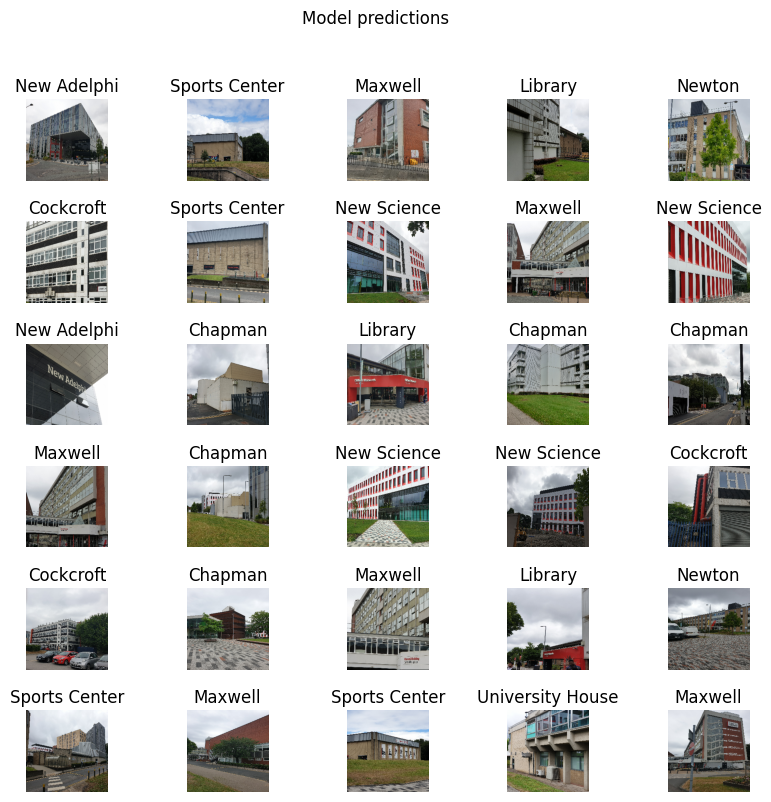

In [40]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

## Export and reload your model

Now that you've trained the model, export it as a SavedModel for reusing it later.

In [42]:
import time  # Import the time module
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
model.save(export_path)

export_path

'/tmp/saved_models/1729730870'

Confirm that you can reload the SavedModel and that the model is able to output the same results:

In [43]:
reloaded = tf.keras.models.load_model(export_path)

In [44]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

1/1 [==============================] - 2s 2s/step


In [45]:
abs(reloaded_result_batch - result_batch).max()

0.0

In [46]:
reloaded_predicted_id = tf.math.argmax(reloaded_result_batch, axis=-1)
reloaded_predicted_label_batch = class_names[reloaded_predicted_id]
print(reloaded_predicted_label_batch)

['New Adelphi' 'Sports Center' 'Maxwell' 'Library' 'Newton' 'Cockcroft'
 'Sports Center' 'New Science' 'Maxwell' 'New Science' 'New Adelphi'
 'Chapman' 'Library' 'Chapman' 'Chapman' 'Maxwell' 'Chapman' 'New Science'
 'New Science' 'Cockcroft' 'Cockcroft' 'Chapman' 'Maxwell' 'Library'
 'Newton' 'Sports Center' 'Maxwell' 'Sports Center' 'University House'
 'Maxwell' 'Chapman' 'Maxwell']


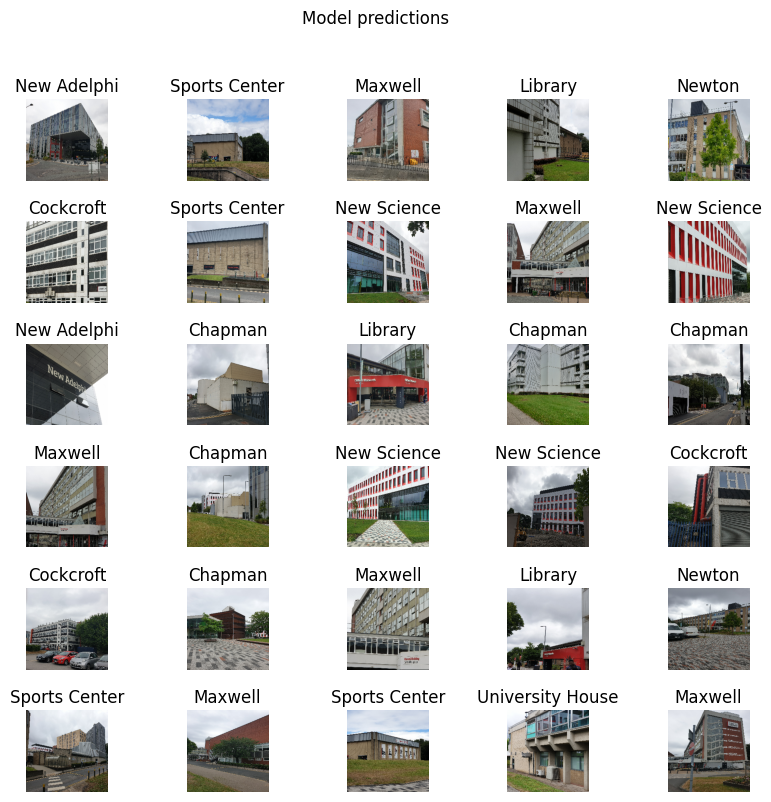

In [47]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(reloaded_predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

You can use the SavedModel to load for inference or convert it to a [TensorFlow Lite](https://www.tensorflow.org/lite/models/convert/)  model (for on-device machine learning) or a [TensorFlow.js](https://www.tensorflow.org/js/tutorials#convert_pretrained_models_to_tensorflowjs) model (for machine learning in JavaScript).
